In [2]:
import sys
!{sys.executable} -m pip install pandas kaggle numpy matplotlib seaborn opencv-python pillow tensorflow scikit-learn keras-tuner gensim


In [3]:
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import seaborn
import numpy as np
import tensorflow as tf


# Problem & Data

**I am looking to determine whether or not a tweet is about a natural disaster based on the content of the tweet. This is a classification task.**

In [3]:
!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
with zipfile.ZipFile("nlp-getting-started.zip", 'r') as zip_ref:
    zip_ref.extractall("nlp-getting-started-data/")


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# grab the data
data = pd.read_csv("nlp-getting-started-data/train.csv")
test_data = pd.read_csv("nlp-getting-started-data/test.csv")

# lets take a look at a samle of the data
print("Tran data:\n")
print(data.head())

print("\n\nTest data:\n")
print(test_data.head())

Tran data:

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


Test data:

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Ta

**There are 7613 tweets in the training data source.**

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


# EDA

**There are a number of entries that are missing keyword and/or location data. Because this I am focused solely on the text content of each tweet, I am going to remove these columns.**

In [8]:
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
# drop keyword and location columns that I am not interested in
data = data.drop('keyword', axis=1)
data = data.drop('location', axis=1)

In [10]:
# take a look at a sample after removing columns
print(data.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1


In [11]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB
None


In [12]:
data.isnull().sum()

id        0
text      0
target    0
dtype: int64

**Next, I will plot the dstribution of number of tweets between Not Distaster (0) and Disaster (1).**

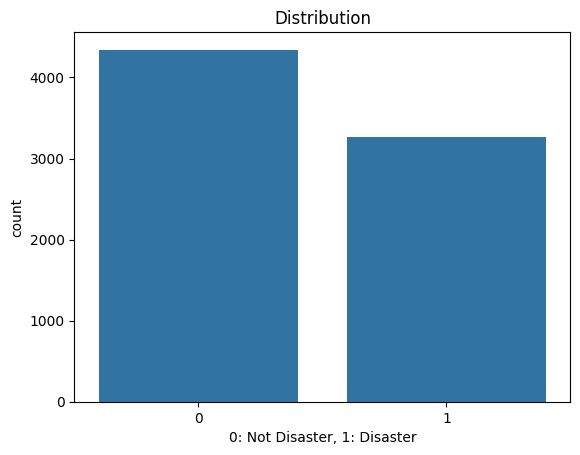

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

In [13]:
seaborn.countplot(x='target', data=data)
plt.title('Distribution')
plt.xlabel('0: Not Disaster, 1: Disaster')
plt.show()
data['target'].value_counts(normalize=True)


**Next, I'll look at the distribution of word count by looking at the number of tweets with the number of words per tweet.**

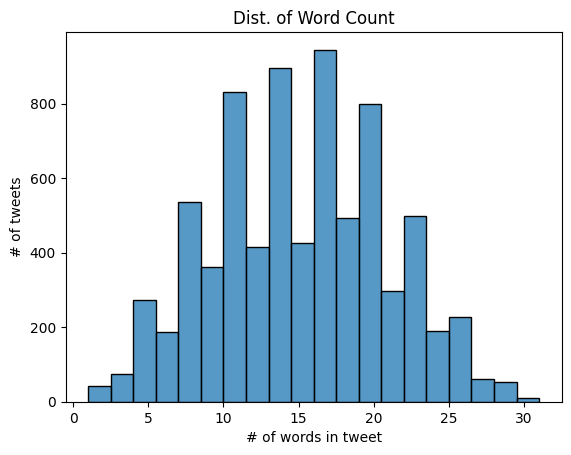

In [14]:
data['word_count'] = data['text'].apply(lambda x: len(x.split()))
data['text_length'] = data['text'].apply(len)

seaborn.histplot(data['word_count'], bins=20)
plt.title("Dist. of Word Count")
plt.xlabel('# of words in tweet')
plt.ylabel('# of tweets')
plt.show()

**Below, we can see that the mean length of the tweets in 0 and 1 are similar.**

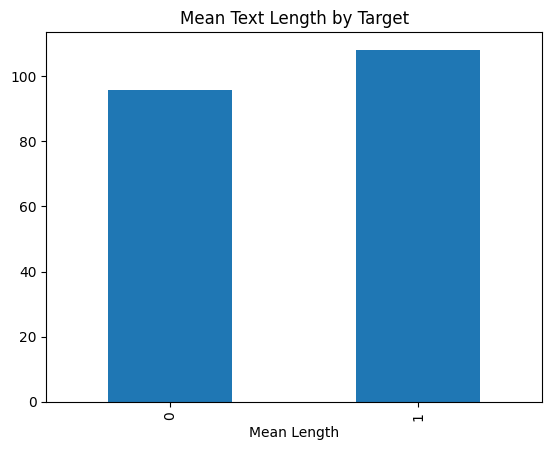

In [15]:
data.groupby('target')['text_length'].mean().plot(kind='bar')
plt.title("Mean Text Length by Target")
plt.xlabel('Mean Length')
plt.show()

**Now, I'll clean the dataset further by removing characters from the tweets that are not condusive to machine learning tasks.**

In [6]:
import re
import string

def clean(txt):
    txt = txt.lower()
    txt = re.sub(r'http\S+|www\S+|https\S+', '', txt, flags=re.MULTILINE)
    txt = re.sub(r'\@\w+|\#', '', txt)
    txt = re.sub(r'[^\w\s]', '', txt)
    return txt
data['cleaned_text'] = data['text'].apply(clean)
data.head()


,id,text,target,cleaned_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [7]:
# check for NaN and Inf values in target 
data['target'] = data['target'].astype(float)
print(np.isnan(data['target']).sum())
print(np.isinf(data['target']).sum())

0
0


**Next, I split the columns into X and Y to prepare for training.**

In [8]:
from sklearn.model_selection import train_test_split

X = data['cleaned_text']
y = data['target']

**Word embedding:** I chose to use Word2Vec with padded sequences for word embeddings. This method transforms the words into vectors and captures semantic relationships between words using a neural network with one hidden layer. I am padding the sequences to ensure that the sequences are the same length for ML tasks.

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X)

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

max_sequence_length = 12

# tokenize X
X_tokenized = [tweet.split() for tweet in X]

word2vec_model = Word2Vec(sentences=X_tokenized, vector_size=100, window=5, min_count=1, workers=4)

vocab_size = len(word_index) + 1
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# split the data into train and validation
X_train, X_val, y_train, y_val = train_test_split(sequences, y, test_size=0.2, random_state=42)

# I'll pad the sequences so they are of equal lengths for training and evaluation
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_sequence_length, padding='post')

In [11]:
print(X_train.shape)
print(y_val.shape)

(6090, 12)
(1523,)


# Model Building & Training

I have chosen to evaluate architecture structures that used 3 different types of layers

* LSTM - Suitable for NLP because they're designed to process sequences.
* GRU - Similar to LSTM but simpler.
* CNN - I wanted to try this due to its potential ability to find patterns in the tweets.

For each architecture I compare, I have an embedding layer that takes the embedding matrix I during preprocessing using Word2Vec. This improves efficiency by allowing the model to work with dense vectors representing words and generalize word meanings.

After evaluating performance of each of my architectures, I decided to proceed with LSTM for hyperparameter tuning.

For evaluation, I looked at F1 score as well as accuracy and AUC.

### Architecture with LSTM

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.metrics import AUC

In [14]:
model_baseline = Sequential()

model_baseline.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    weights=[embedding_matrix],
                    trainable=True))

model_baseline.add(LSTM(128, return_sequences=False))

model_baseline.add(Dense(1, activation='sigmoid'))

model_baseline.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])

In [25]:
history_baseline = model_baseline.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)


Epoch 1/30


2024-10-08 06:30:10.012233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.5817 - auc: 0.5643 - loss: 0.6739 - val_accuracy: 0.7781 - val_auc: 0.8259 - val_loss: 0.4845
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.8356 - auc: 0.8982 - loss: 0.3839 - val_accuracy: 0.7827 - val_auc: 0.8418 - val_loss: 0.4732
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9223 - auc: 0.9739 - loss: 0.2069 - val_accuracy: 0.7584 - val_auc: 0.8254 - val_loss: 0.6168
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9639 - auc: 0.9897 - loss: 0.1157 - val_accuracy: 0.7354 - val_auc: 0.8178 - val_loss: 0.6924
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9721 - auc: 0.9947 - loss: 0.0820 - val_accuracy: 0.7242 - val_auc: 0.8095 - val_loss: 0.7783
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.9765 - auc: 0.9970 - loss: 0.0639 - val_accuracy: 0.7249 - val_auc: 0.8023 - val_loss: 0.8662
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - 

In [26]:
model_baseline.evaluate(X_val, y_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7177 - auc: 0.7641 - loss: 1.5961


[1.60102117061615, 0.7209455370903015, 0.7695610523223877]

In [27]:
y_val_pred_base = model_baseline.predict(X_val)
y_val_pred_base = (y_val_pred_base > 0.5).astype(int)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


In [25]:
from sklearn.metrics import classification_report

In [29]:
print(classification_report(y_val, y_val_pred_base, target_names=['Non-Disaster', 'Disaster']))

              precision    recall  f1-score   support

Non-Disaster       0.76      0.75      0.75       874
    Disaster       0.67      0.69      0.68       649

    accuracy                           0.72      1523
   macro avg       0.72      0.72      0.72      1523
weighted avg       0.72      0.72      0.72      1523



### Architecture with GRU

In [30]:
# trying alternative architecture holding everything else constant
from tensorflow.keras.layers import GRU

model_gru = Sequential()

model_gru.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        trainable=False))

model_gru.add(GRU(128, return_sequences=False))

model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.5707 - auc_1: 0.4797 - loss: 0.6887 - val_accuracy: 0.5443 - val_auc_1: 0.5585 - val_loss: 0.6846
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.5702 - auc_1: 0.5405 - loss: 0.6812 - val_accuracy: 0.5765 - val_auc_1: 0.6182 - val_loss: 0.6709
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5685 - auc_1: 0.5747 - loss: 0.6783 - val_accuracy: 0.5745 - val_auc_1: 0.6216 - val_loss: 0.6691
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5927 - auc_1: 0.6108 - loss: 0.6682 - val_accuracy: 0.6225 - val_auc_1: 0.6457 - val_loss: 0.6570
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.6167 - auc_1: 0.6373 - loss: 0.6586 - val_accuracy: 0.6231 - val_auc_1: 0.6620 - val_loss: 0.6496
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.6096 - auc_1: 0.6415 - loss: 0.6578 - val_accuracy: 0.6198 - val_auc_1: 0.6759 - val_loss: 0.6496
Epoch 7/10
96/96 ━━━━

In [31]:
model_gru.evaluate(X_val, y_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6397 - auc_1: 0.7178 - loss: 0.6399


[0.6364011168479919, 0.6428102254867554, 0.7121147513389587]

In [32]:
y_val_pred_gru = model_gru.predict(X_val)
y_val_pred_gru = (y_val_pred_gru > 0.5).astype(int)
print(classification_report(y_val, y_val_pred_gru, target_names=['Non-Disaster', 'Disaster']))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

Non-Disaster       0.62      0.97      0.76       874
    Disaster       0.83      0.20      0.33       649

    accuracy                           0.64      1523
   macro avg       0.73      0.59      0.54      1523
weighted avg       0.71      0.64      0.57      1523



### Architecture with CNN

In [33]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# comparing CNN
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        trainable=False))
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])
history_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5426 - auc_2: 0.5338 - loss: 0.7077 - val_accuracy: 0.6343 - val_auc_2: 0.6612 - val_loss: 0.6508
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6123 - auc_2: 0.6345 - loss: 0.6586 - val_accuracy: 0.6382 - val_auc_2: 0.6722 - val_loss: 0.6431
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6127 - auc_2: 0.6460 - loss: 0.6500 - val_accuracy: 0.6566 - val_auc_2: 0.6841 - val_loss: 0.6282
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6355 - auc_2: 0.6659 - loss: 0.6391 - val_accuracy: 0.6428 - val_auc_2: 0.6802 - val_loss: 0.6437
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6544 - auc_2: 0.6927 - loss: 0.6245 - val_accuracy: 0.6697 - val_auc_2: 0.6921 - val_loss: 0.6212
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6466 - auc_2: 0.6877 - loss: 0.6282 - val_accuracy: 0.6454 - val_auc_2: 0.6897 - val_loss: 0.6400
Epoch 7/30
96/96 ━━━━━

In [34]:
model_cnn.evaluate(X_val, y_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6765 - auc_2: 0.7148 - loss: 0.6100


[0.6037609577178955, 0.6789231896400452, 0.718971848487854]

In [35]:
y_val_pred_cnn = model_cnn.predict(X_val)
y_val_pred_cnn = (y_val_pred_cnn > 0.5).astype(int)
print(classification_report(y_val, y_val_pred_cnn, target_names=['Non-Disaster', 'Disaster']))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

Non-Disaster       0.67      0.85      0.75       874
    Disaster       0.69      0.45      0.54       649

    accuracy                           0.68      1523
   macro avg       0.68      0.65      0.65      1523
weighted avg       0.68      0.68      0.66      1523



## Hyperparameter Tuning

Below, I try a number of different combinations of hyperparameters to try to improve performance. 

I tried various combinations of LSTM units, dropout rates, learning rates, and optimizers.

I found that this process took the longest -- both in terms of coding the process and letting it run.

In [15]:
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, SGD
from tensorflow.keras.layers import Bidirectional

def build_model(hyperparams):
    model_t = Sequential()

    model_t.add(Embedding(input_dim=vocab_size,  output_dim=embedding_dim, weights=[embedding_matrix], trainable=True))

    lstm_units = hyperparams.Int('lstm_units', min_value=32, max_value=256, step=32)
    
    model_t.add(LSTM(units=lstm_units, return_sequences=True))
    model_t.add(LSTM(units=lstm_units, return_sequences=True))
    model_t.add(LSTM(units=lstm_units, return_sequences=False))
    
    
    dropout_rate = hyperparams.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model_t.add(Dropout(dropout_rate))

    l2_reg = hyperparams.Float('l2_reg', min_value=1e-4, max_value=1e-2, sampling='log')
    model_t.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg)))

    
    learning_rate = hyperparams.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    optimizer_choice = hyperparams.Choice('optimizer', ['adam', 'sgd'])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

   
    model_t.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                   metrics=['accuracy', AUC()])
    print(X_train.shape)
    print(X_val.shape)
    print(model_t.summary())
    return model_t


In [16]:
tuner = RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=50,
    executions_per_trial=1,
    directory='out_7',
    project_name='disaster_12'
)

tuner.search_space_summary()


Reloading Tuner from out_7/disaster_12/tuner0.json
Search space summary
Default search space size: 5
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
l2_reg (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=5, min_lr=1e-5)

tuner.search(X_train, y_train, 
             epochs=30, 
             batch_size=32, 
             validation_data=(X_val, y_val), 
             callbacks=[early_stopping, lr_scheduler])

In [18]:

best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hparams)



(6090, 12)
(1523, 12)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,588,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,588,000 (6.06 MB)

 Trainable params: 1,588,000 (6.06 MB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
for param, value in best_hparams.values.items():
    print(f"{param}: {value}")

lstm_units: 256
dropout_rate: 0.30000000000000004
l2_reg: 0.0001792680161103088
learning_rate: 0.00017887307871975
optimizer: adam


In [22]:

early_stopping = EarlyStopping(monitor='val_auc_3', mode='max', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_auc_3', factor=0.2, patience=5, min_lr=1e-5)

history_best_model = best_model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler]
                )

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.7865 - auc_3: 0.8367 - loss: 0.4826 - val_accuracy: 0.7649 - val_auc_3: 0.8334 - val_loss: 0.4875 - learning_rate: 1.7887e-04
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.8565 - auc_3: 0.9193 - loss: 0.3471 - val_accuracy: 0.7794 - val_auc_3: 0.8389 - val_loss: 0.4913 - learning_rate: 1.7887e-04
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.8989 - auc_3: 0.9527 - loss: 0.2667 - val_accuracy: 0.7794 - val_auc_3: 0.8333 - val_loss: 0.5549 - learning_rate: 1.7887e-04
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.9219 - auc_3: 0.9725 - loss: 0.2043 - val_accuracy: 0.7695 - val_auc_3: 0.8256 - val_loss: 0.6118 - learning_rate: 1.7887e-04
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9442 - auc_3: 0.9850 - loss: 0.1521 - val_accuracy: 0.7702 - val_auc_3: 0.8157 - val_loss: 0.6950 - learning_rate: 1.7887e-04
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━

In [23]:
val_loss, val_acc, _ = best_model.evaluate(X_val, y_val)
print(f"Test acc: {val_acc}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7637 - auc_3: 0.8298 - loss: 0.5101
Test acc: 0.7793828248977661


In [26]:
y_val_pred_best = best_model.predict(X_val)
y_val_pred_best = (y_val_pred_best > 0.5).astype(int)
print(classification_report(y_val, y_val_pred_best, target_names=['Non-Disaster', 'Disaster']))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

Non-Disaster       0.76      0.90      0.82       874
    Disaster       0.82      0.62      0.70       649

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.76      1523
weighted avg       0.79      0.78      0.77      1523



## Predicting for Kaggle Submission

In [28]:
test_data.head()

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [32]:
# test data
test_data['cleaned_text'] = test_data['text'].apply(clean)

X_test = test_data['cleaned_text'] 

sequences_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

predictions = best_model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
predictions = predictions.flatten()

submission = pd.DataFrame({
    'id': test_data['id'],
    'target': predictions
})

submission.to_csv('submission.csv', index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


# Results

My submission generated above received a score of 0.78057 when submitted to the Kaggle competition.

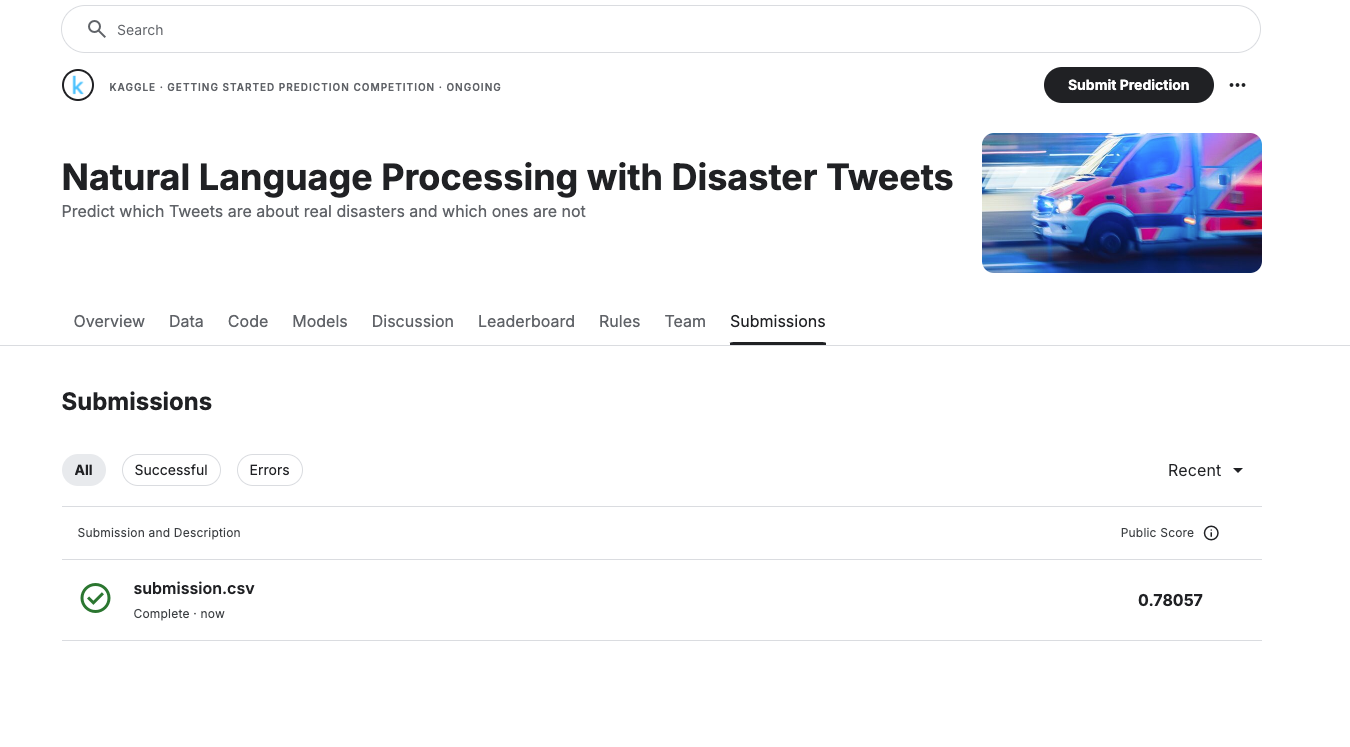

Through tuning hyperparameters, I was able to improve the AUC metric and improve my model that I used in the Kaggle submission.

Along with the tough aspect of waiting time finding the right hyperparameters to tune took some trial and error.

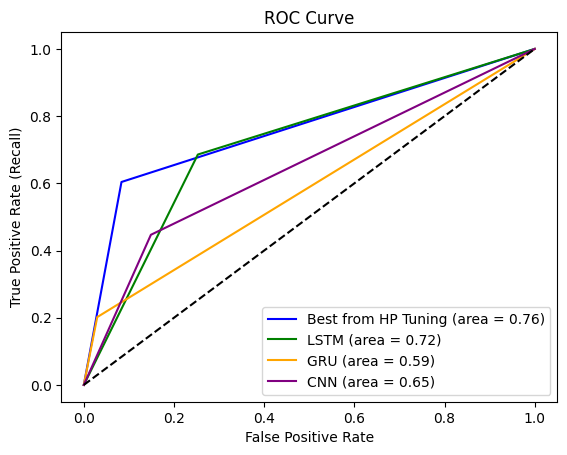

In [44]:
# ROC

from sklearn.metrics import roc_curve, auc

preds = [y_val_pred_best, y_val_pred_base, y_val_pred_gru, y_val_pred_cnn]
names = ['Best from HP Tuning', 'LSTM', 'GRU', 'CNN']
colors= ['blue', 'green', 'orange', 'purple']
plt.figure()

for i, pred in enumerate(preds):
    fpr, tpr, _ = roc_curve(y_val, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], label=f'{names[i]} (area = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Discussion & Conclusion

I was able to successfully iterate on my models and improve my AUC. 

I learned how to utilize my GPU within a Jupyter notebook -- which I thought was pretty cool.

Increasing the number of LSTM layers really seemed to help my project. 

In the future, I would like to be able to try more hyperparameter combinations and broaden my search to better improve performance. This would be possible without time and computing resource constraints.

*I used ChatGPT 4o throughout this project to help understand and implement concepts and processes.*